Loads


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [3]:
cd /gdrive/My\ Drive/nn 

/gdrive/My Drive/nn


In [4]:
%tensorflow_version 1.x
import argparse
import os
import pickle
import sys
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn')
mpl.use('Agg')
%matplotlib inline

import numpy as np

np.random.seed(7)  # for reproducibility

import tensorflow as tf
tf.random.set_random_seed(5005)

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import class_weight


from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.pooling import MaxPooling1D
from tensorflow.python.keras.layers.pooling import AveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.python.keras.backend as K
from keras import regularizers
from tensorflow.python.keras.utils import plot_model 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc , f1_score, classification_report

sys.path.append(".")
import utils
from utils import *

l2_lam = 5e-07 
l1_lam = 1e-08 

TensorFlow 1.x selected.


Using TensorFlow backend.


Run on the zhou dataset

In [5]:
zhou_models_folder="./models/folds_models/covariance/5-folds"
zhou_all_data = r"dataset/covariance/bulk_prone_0.0153/bulk.pkl"

_,_,_,_, x_test_seq, y_test, _, _ = load_train_validate_test_data(zhou_all_data, input_len=150, kfold=1, only_test=True)

test_seqs = vecs2dna(x_test_seq)

models = load_models(zhou_models_folder)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
# Get the scores for the dataset
get_scores(models,x_test_seq, y_test)
y_pred =  predict(models, x_test_seq)
f1 = f1_score(y_test, np.round(y_pred))
print("F1 score is %s" % (f1))
print(classification_report(y_test, np.round(y_pred)))

1059338/1059338 [==============================] - 70s 66us/sample - loss: 0.3336 - acc: 0.8678 - recall_TP: 0.8840 - recall_TN: 0.8658
Average scores for all folds:
> Accuracy: 86.86158776283264 (+- 0.20053461951799514)
> Loss: 0.3213262729217861
>Truee accuracy using majority vote: 0.872701630641023
> AUC: 0.944390955958202
> Recall: 0.874245318088011
F1 score is 0.8018257915094228


'              precision    recall  f1-score   support\n\n         0.0       0.94      0.87      0.91    747286\n         1.0       0.74      0.87      0.80    312052\n\n    accuracy                           0.87   1059338\n   macro avg       0.84      0.87      0.85   1059338\nweighted avg       0.88      0.87      0.88   1059338\n'

In [23]:
# Predict based on label 0
y_pred = np.zeros_like(y_test)
total_density_prediction = np.sum((y_test -y_pred) == 0)
accuracy = total_density_prediction / y_test.shape[0] * 100
print("Accuracy using only 0 %s" %accuracy)

Accuracy using only 0 70.54273517989536


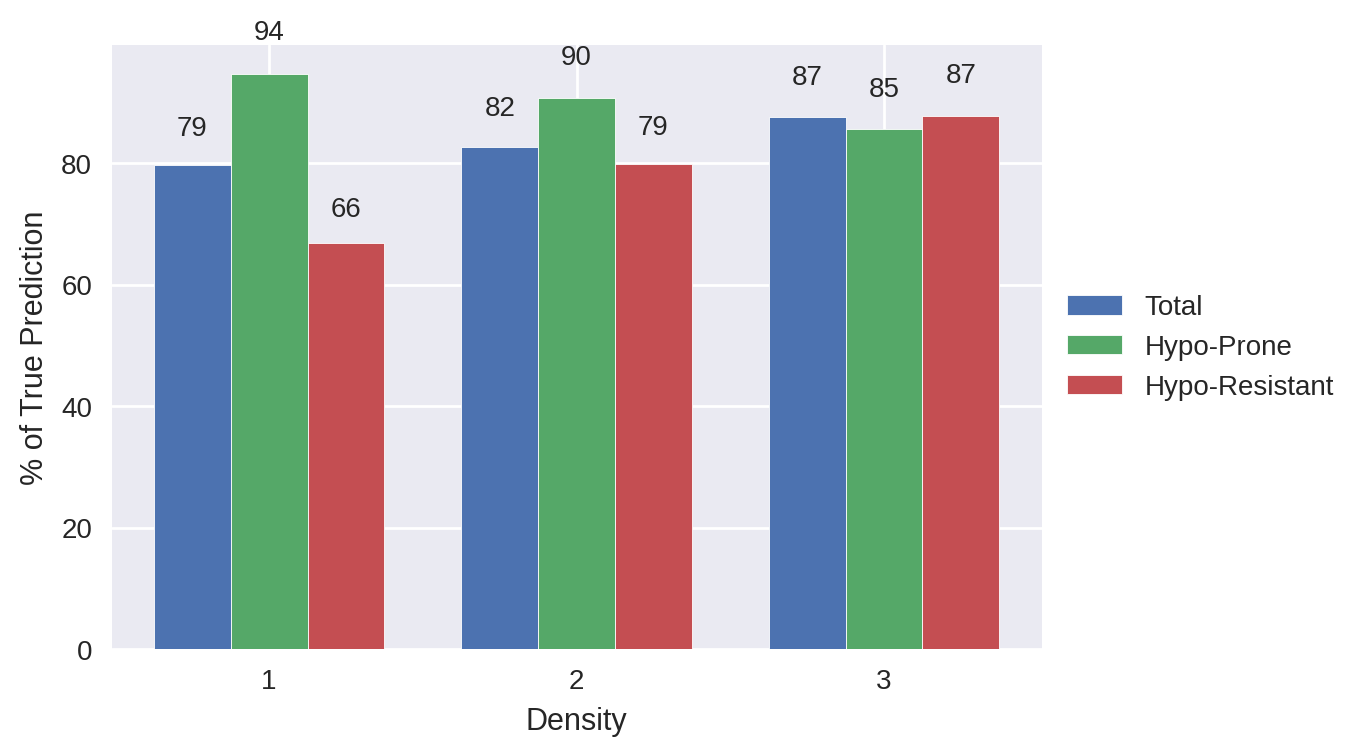

In [8]:
# Create accuracy list per label per density
accuracy_list = []
prone_accuracy_list = []
resist_accuracy_list = []
for density_value in range(1,4):
  density_indexes = [i for i in range(len(test_seqs)) if (test_seqs[i].count("CG") == density_value)]
  y_pred =  np.round(predict(models, x_test_seq[density_indexes]))
  density_y_test = y_test[density_indexes]

  # Total
  total_density_prediction = np.sum((density_y_test -y_pred) == 0)
  accuracy = total_density_prediction / density_y_test.shape[0] * 100
  accuracy_list.append(accuracy)

  # Prone
  second_ind = density_y_test == 1
  prone_y_pred = y_pred[second_ind]
  y_good= density_y_test[second_ind]
  total_density_prediction = np.sum((y_good -prone_y_pred) == 0)
  if prone_y_pred.shape[0] == 0:
    accuracy = -1
  else:
    accuracy = total_density_prediction / prone_y_pred.shape[0] * 100
  prone_accuracy_list.append(accuracy)

  # Resist
  second_ind = density_y_test == 0
  resist_y_pred = y_pred[second_ind]
  y_good= density_y_test[second_ind]
  total_density_prediction = np.sum((y_good -resist_y_pred) == 0)
  if resist_y_pred.shape[0] == 0:
    accuracy = -1
  else:
    accuracy = total_density_prediction / resist_y_pred.shape[0] * 100
  resist_accuracy_list.append(accuracy)

ind = np.arange(3)  
width = 0.25       # the width of the bars

fig = plt.figure(1, dpi=200)
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, accuracy_list, width, edgecolor='white', label="Total")
rects2 = ax.bar(ind+width, prone_accuracy_list, width,edgecolor='white', label="Hypo-Prone")
rects3 = ax.bar(ind+width*2, resist_accuracy_list, width, edgecolor='white', label="Hypo-Resistant")

ax.set_ylabel('% of True Prediction')
ax.set_xlabel("Density")
ax.set_xticks(ind+width)
ax.set_xticklabels( ["1","2","3"])

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


Precision recall curve

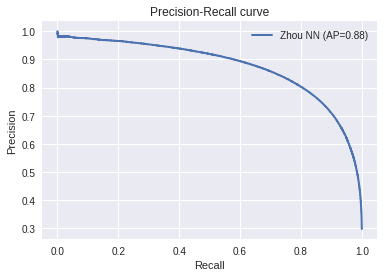

In [26]:
y_pred =  predict(models, x_test_seq)
precision_bulk, recall_bulk, _ = precision_recall_curve(y_test,y_pred)
average_precision_bulk = average_precision_score(y_test,y_pred)
pr_auc_bulk= auc(recall_bulk,precision_bulk)
plt.plot(recall_bulk, precision_bulk, lw=2, label="Zhou NN (AP={0:0.2f})".format(average_precision_bulk))


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.legend(loc='best')
plt.show()

Run on the scwgbs (Bian) dataset

In [9]:
scgwbs_models_folder="./models/folds_models/sc/5-folds"
scgwbs_data = r"dataset/scwgbs_crc01_dataset/scwgbs1_crc01.pkl"

_,_,_,_, x_test_seq, y_test, _, _ = load_train_validate_test_data(scgwbs_data, input_len=150, kfold=1, only_test=True)

test_seqs = vecs2dna(x_test_seq)
models = load_models(scgwbs_models_folder)

In [28]:
# Get the scores for the dataset
get_scores(models,x_test_seq, y_test)
y_pred =  predict(models, x_test_seq)
f1 = f1_score(y_test, np.round(y_pred))
print("F1 score is %s" % (f1))
print(classification_report(y_test, np.round(y_pred)))

692818/692818 [==============================] - 51s 73us/sample - loss: 0.5343 - acc: 0.7685 - recall_TP: 0.8029 - recall_TN: 0.7590
Average scores for all folds:
> Accuracy: 75.60548305511475 (+- 1.2466294308082249)
> Loss: 0.5422358867371102
>Truee accuracy using majority vote: 0.7615997274897592
> AUC: 0.8701296311983429
> Recall: 0.8365745839682563
F1 score is 0.5731695971718299
              precision    recall  f1-score   support

         0.0       0.95      0.74      0.83    560256
         1.0       0.44      0.84      0.57    132562

    accuracy                           0.76    692818
   macro avg       0.69      0.79      0.70    692818
weighted avg       0.85      0.76      0.78    692818



In [29]:
# Predict based on label 0
y_pred = np.zeros_like(y_test)
total_density_prediction = np.sum((y_test -y_pred) == 0)
accuracy = total_density_prediction / y_test.shape[0] * 100
print("Accuracy using only 0 %s" %accuracy)

Accuracy using only 0 80.86625924846064


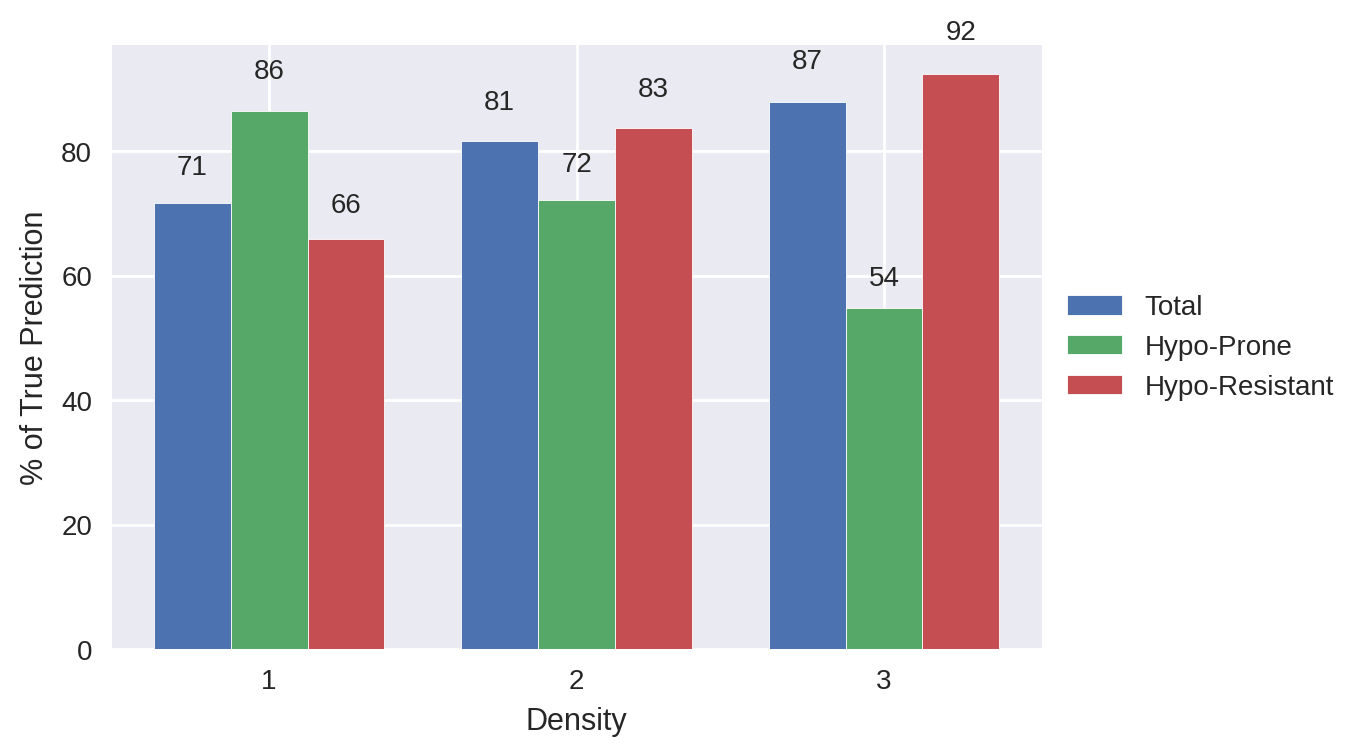

In [13]:
# Create accuracy list per label per density
accuracy_list = []
prone_accuracy_list = []
resist_accuracy_list = []
for density_value in range(1,4):
  density_indexes = [i for i in range(len(test_seqs)) if (test_seqs[i].count("CG") == density_value)]
  y_pred =  np.round(predict(models, x_test_seq[density_indexes]))
  density_y_test = y_test[density_indexes]

  # Total
  total_density_prediction = np.sum((density_y_test -y_pred) == 0)
  accuracy = total_density_prediction / density_y_test.shape[0] * 100
  accuracy_list.append(accuracy)

  # Prone
  second_ind = density_y_test == 1
  prone_y_pred = y_pred[second_ind]
  y_good= density_y_test[second_ind]
  total_density_prediction = np.sum((y_good -prone_y_pred) == 0)
  if prone_y_pred.shape[0] == 0:
    accuracy = -1
  else:
    accuracy = total_density_prediction / prone_y_pred.shape[0] * 100
  prone_accuracy_list.append(accuracy)

  # Resist
  second_ind = density_y_test == 0
  resist_y_pred = y_pred[second_ind]
  y_good= density_y_test[second_ind]
  total_density_prediction = np.sum((y_good -resist_y_pred) == 0)
  if resist_y_pred.shape[0] == 0:
    accuracy = -1
  else:
    accuracy = total_density_prediction / resist_y_pred.shape[0] * 100
  resist_accuracy_list.append(accuracy)

ind = np.arange(3)  
width = 0.25       # the width of the bars

fig = plt.figure(1, dpi=200)
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, accuracy_list, width, edgecolor='white', label="Total")
rects2 = ax.bar(ind+width, prone_accuracy_list, width,edgecolor='white', label="Hypo-Prone")
rects3 = ax.bar(ind+width*2, resist_accuracy_list, width, edgecolor='white', label="Hypo-Resistant")

ax.set_ylabel('% of True Prediction')
ax.set_xlabel("Density")
ax.set_xticks(ind+width)
ax.set_xticklabels( ["1","2","3"])

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


Precision recall curve

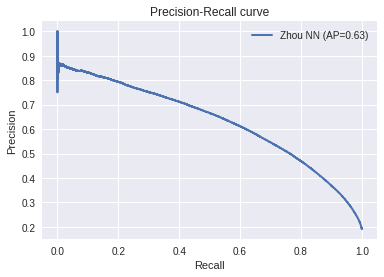

In [31]:
y_pred =  predict(models, x_test_seq)
precision_bulk, recall_bulk, _ = precision_recall_curve(y_test,y_pred)
average_precision_bulk = average_precision_score(y_test,y_pred)
pr_auc_bulk= auc(recall_bulk,precision_bulk)
plt.plot(recall_bulk, precision_bulk, lw=2, label="Zhou NN (AP={0:0.2f})".format(average_precision_bulk))


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.legend(loc='best')
plt.show()